In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from imblearn.combine import SMOTEENN
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/skin cancer/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:
X = data.iloc[:,:2352]
y = data.iloc[:,-1]

In [ ]:
y.value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [ ]:
unique_classes, class_counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Kelas {cls}: {count} sampel")

Kelas 0: 327 sampel
Kelas 1: 514 sampel
Kelas 2: 1099 sampel
Kelas 3: 115 sampel
Kelas 4: 6705 sampel
Kelas 5: 142 sampel
Kelas 6: 1113 sampel


In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled_df = smote_enn.fit_resample(X, y)

# Jumlah kelas setelah resampling
unique_classes, class_counts = np.unique(y_resampled_df, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Kelas {cls}: {count} sampel")

Kelas 0: 6705 sampel
Kelas 1: 6702 sampel
Kelas 2: 6597 sampel
Kelas 3: 6705 sampel
Kelas 4: 3464 sampel
Kelas 5: 6705 sampel
Kelas 6: 6595 sampel


In [ ]:
X_resampled = np.array(X_resampled).reshape(-1, 28, 28, 3)
print('Shape of Data :', X_resampled.shape)

Shape of Data : (43473, 28, 28, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_resampled = np.array(y_resampled_df)
y_resampled = to_categorical(y_resampled)
print('Shape of Data :', y_resampled.shape)

Shape of Data : (43473, 7)


In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X_resampled , y_resampled , test_size = 0.25 , random_state = 42)

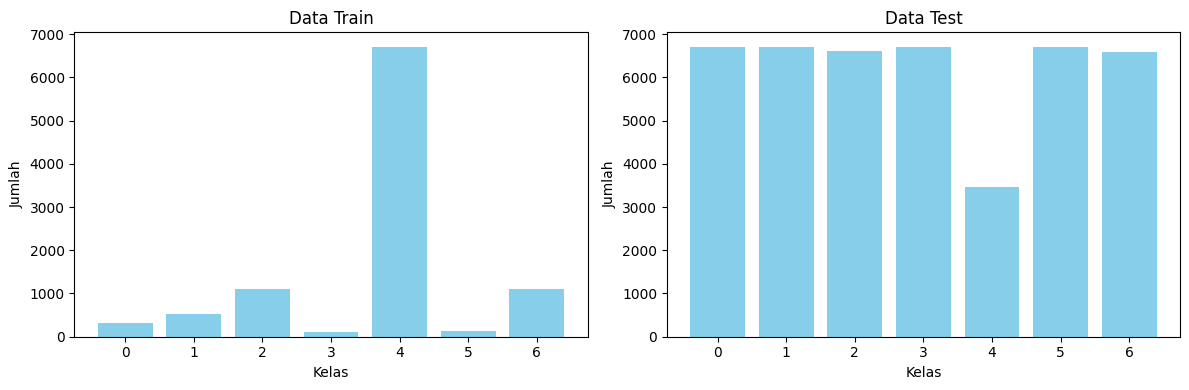

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

class_counts = y.value_counts().sort_index()
ax1.bar(class_counts.index, class_counts.values, color='skyblue')
ax1.set_xlabel('Kelas')
ax1.set_ylabel('Jumlah')
ax1.set_title('Data Train')

class_counts_SMOTEENN = y_resampled_df.value_counts().sort_index()
ax2.bar(class_counts_SMOTEENN.index, class_counts_SMOTEENN.values, color='skyblue')
ax2.set_xlabel('Kelas')
ax2.set_ylabel('Jumlah')
ax2.set_title('Data Test')

plt.tight_layout()
plt.show()


In [ ]:
model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(7, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
# Callback untuk menyimpan model terbaik
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Hanya menyimpan model terbaik
    monitor='val_loss',  # Monitor validasi loss
    mode='min',  # Mode minimisasi untuk validasi loss
    verbose=1  # Menampilkan pesan ketika menyimpan model
)

# Callback untuk mengurangi learning rate saat validasi loss stagnan
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validasi loss
    factor=0.2,  # Faktor pengurangan learning rate (0.2 = 20%)
    patience=3,  # Jumlah epoch tanpa perubahan sebelum mengurangi learning rate
    min_lr=0.0001,  # Batas bawah learning rate
    verbose=1  # Menampilkan pesan ketika mengurangi learning rate
)

# Callback untuk menghentikan pelatihan jika validasi loss tidak berubah dalam beberapa epoch
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validasi loss
    patience=5,  # Jumlah epoch tanpa perubahan sebelum menghentikan pelatihan
    verbose=1,  # Menampilkan pesan ketika menghentikan pelatihan
    restore_best_weights=True  # Mengembalikan bobot terbaik saat menghentikan pelatihan
)

# **Egitim** **Kısmı**

In [ ]:
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=70,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback, reduce_lr_callback, early_stopping_callback]
)

end_time = time.time()
training_time = (end_time - start_time)/60
print(f"Total waktu pelatihan: {training_time} menit")

Epoch 1/70
1019/1019 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.6923
Epoch 1: val_loss improved from inf to 2.18523, saving model to best_model.h5
1019/1019 [==============================] - 238s 229ms/step - loss: 0.8474 - accuracy: 0.6923 - val_loss: 2.1852 - val_accuracy: 0.4784 - lr: 0.0010
Epoch 2/70


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8349
Epoch 2: val_loss improved from 2.18523 to 0.57511, saving model to best_model.h5
1019/1019 [==============================] - 245s 241ms/step - loss: 0.4627 - accuracy: 0.8349 - val_loss: 0.5751 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 3/70
1019/1019 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8911
Epoch 3: val_loss did not improve from 0.57511
1019/1019 [==============================] - 229s 225ms/step - loss: 0.3118 - accuracy: 0.8911 - val_loss: 0.9746 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 4/70
1019/1019 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9228
Epoch 4: val_loss did not improve from 0.57511
1019/1019 [==============================] - 227s 223ms/step - loss: 0.2237 - accuracy: 0.9228 - val_loss: 0.7041 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 5/70
1019/1019 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 

# **Hiper parametrelere bağlı grafik degerleri **

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


plot_training(model.predict)

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

340/340 [==============================] - 15s 44ms/step - loss: 4.1953 - accuracy: 0.1563
Train Loss:  4.20957612991333
Train Accuracy:  0.1501656174659729
--------------------
Test Loss:  4.195265769958496
Test Accuracy:  0.1563161313533783


In [ ]:
y_pred = model.predict(X_test)

340/340 [==============================] - 15s 43ms/step


In [ ]:
y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_test , axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.15631612843867881
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1754
           1       0.00      0.00      0.00      1686
           2       0.00      0.00      0.00      1629
           3       0.00      0.00      0.00      1612
           4       0.00      0.00      0.00       864
           5       0.00      0.00      0.00      1625
           6       0.16      1.00      0.27      1699

    accuracy                           0.16     10869
   macro avg       0.02      0.14      0.04     10869
weighted avg       0.02      0.16      0.04     10869



In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

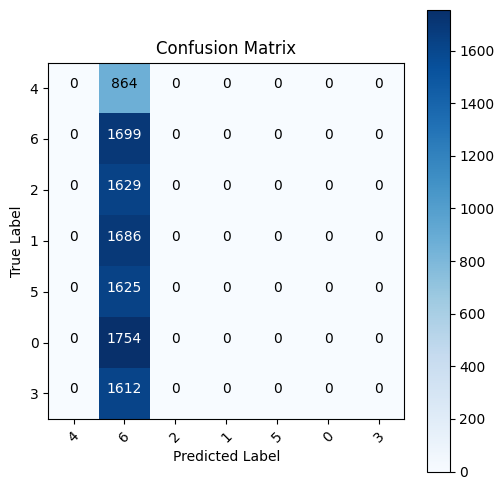

In [ ]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# y_test_unique_classes, y_test_class_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
num = 0
for cls, count in zip(classes_labels, [864, 1699, 1629, 1686, 1625, 1754, 1612]):
    print(f"Kelas {cls}: {cm[num,num]} dari {count} sampel, prediksi salah: {count-cm[num,num]}")
    num += 1

Kelas 4: 0 dari 864 sampel, prediksi salah: 864
Kelas 6: 1699 dari 1699 sampel, prediksi salah: 0
Kelas 2: 0 dari 1629 sampel, prediksi salah: 1629
Kelas 1: 0 dari 1686 sampel, prediksi salah: 1686
Kelas 5: 0 dari 1625 sampel, prediksi salah: 1625
Kelas 0: 0 dari 1754 sampel, prediksi salah: 1754
Kelas 3: 0 dari 1612 sampel, prediksi salah: 1612


In [ ]:
def convertIMG(testing_img):

    img = Image.open(testing_img)
    img_resized = img.resize((28, 28))
    img_rgb = img_resized.convert('RGB')

    img_array = np.array(img_rgb)

    if img_array.shape[2] == 4:  # Jika terdapat alpha channel (transparansi)
        img_array = img_array[:, :, :3]  # Hapus alpha channel

    if img_array.shape[:2] != (28, 28):
        raise ValueError("Ukuran gambar tidak sesuai dengan yang diharapkan")

    return img_array

def getPrediction(testing_img):
    img_input = np.expand_dims(convertIMG(testing_img), axis=0)
    res = np.argmax(model.predict(img_input))

    print(classes[res])

    return res

In [ ]:
testing_img = '/content/drive/MyDrive/Colab Notebooks/skin cancer/ISIC_0034320.jpg'
getPrediction(testing_img)

1/1 [==============================] - 0s 229ms/step
('mel', 'melanoma')


6

https://www.kaggle.com/code/teguhbudi/cnn-skin-cancer